In [25]:
import time
import seaborn as sns
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import CenteredNorm

In [6]:


# Make sure to use a CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the models you want to test
model_names = ["EleutherAI/pythia-70m", "EleutherAI/pythia-160m", "EleutherAI/pythia-410m", "EleutherAI/pythia-1.4b", "EleutherAI/pythia-2.8b"]
model_names = model_names[:3]
# Define the sequence lengths you want to test
sequence_lengths = [128, 256, 512, 1024]

num_iterations = 20

# Initialize the data frame
df = pd.DataFrame(columns=["num_params", "seq_len", "time", "memory"])

# For each model
for model_name in model_names:
    # Load the model and the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)

    # Get the number of parameters
    num_params = sum(p.numel() for p in model.parameters())

    # For each sequence length
    for seq_len in sequence_lengths:
        times = []
        memories = []
        for _ in range(num_iterations):
            # Generate a random sequence of the desired length
            input_ids = torch.randint(0, tokenizer.vocab_size, (1, seq_len)).to(device)
            
            # Record the initial memory usage
            torch.cuda.synchronize()
            mem_before = torch.cuda.memory_allocated()
            torch.cuda.synchronize()

            # Record the initial time
            time_before = time.time()

            # Perform a forward pass through the model
            outputs = model(input_ids)

            # Record the final time
            torch.cuda.synchronize()
            time_after = time.time()

            # Record the final memory usage
            torch.cuda.synchronize()
            mem_after = torch.cuda.memory_allocated()

            # Calculate the time and memory usage
            times.append(time_after - time_before)
            memories.append(mem_after - mem_before)

        # Calculate the average time and memory usage
        avg_time = sum(times) / len(times)
        avg_memory = sum(memories) / len(memories)

        # Add the results to the data frame
        df = df.append({
            "num_params": num_params,
            "seq_len": seq_len,
            "time": avg_time,
            "memory": avg_memory
        }, ignore_index=True)

# Plot the results
sns.relplot(data=df, x="num_params", y="time", hue="seq_len", size="seq_len", kind="line")
sns.relplot(data=df, x="num_params", y="memory", hue="seq_len", size="seq_len", kind="line")
sns.jointplot(data=df, x="num_params", y="time", hue="seq_len", kind="kde")
sns.jointplot(data=df, x="num_params", y="memory", hue="seq_len", kind="kde")

Some weights of the model checkpoint at EleutherAI/pythia-70m were not used when initializing GPTNeoXModel: ['embed_out.weight']
- This IS expected if you are initializing GPTNeoXModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPTNeoXModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AssertionError: Torch not compiled with CUDA enabled

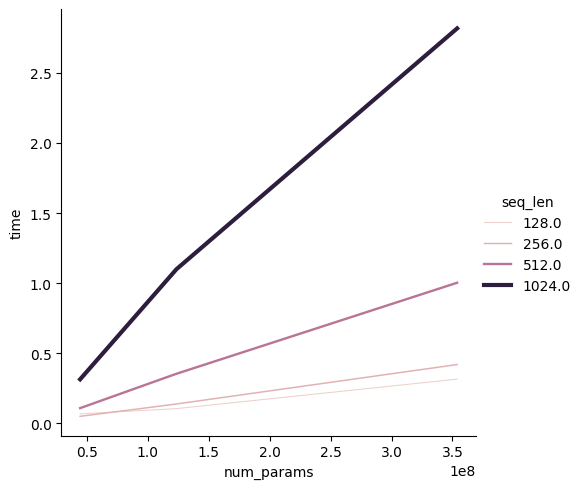

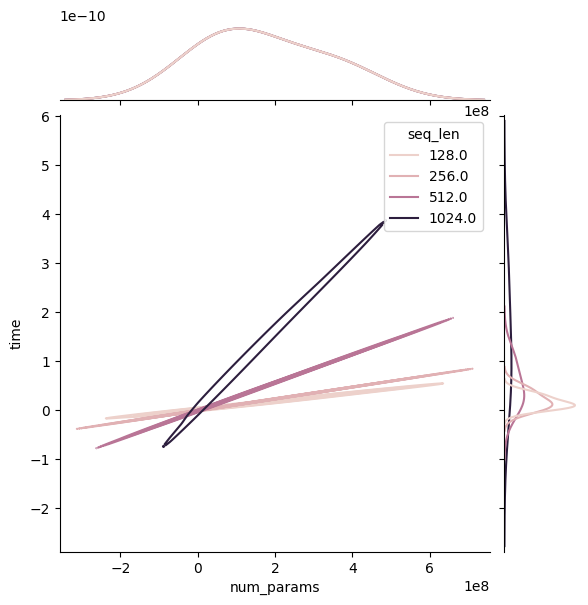

In [5]:
sns.relplot(data=df, x="num_params", y="time", hue="seq_len", size="seq_len", kind="line")
sns.jointplot(data=df, x="num_params", y="time", hue="seq_len", kind="kde")

In [1]:
import os
import json
import random

In [30]:
res = []

for file in os.listdir('generative_res/gpt3.5-review/'):
    path = f'generative_res/gpt3.5-review/{file}'
    print(file)
    if '-vs-' not in file:
        continue
    model1, model2 = file.split('-vs-')
    with open(path) as f:
        data = [json.loads(line) for line in f]
#     res1 = [line['score'][0] for line in data]
#     res2 = [line['score'][1] for line in data]
    diff = [line['score'][0] - line['score'][1] for line in data]
    res.append(dict(model1=model1, model2=model2, result=np.mean(diff)))

RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b-vs-RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b
RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b-vs-RedPajama-INCITE-Instruct-3B-v1
dolly-v2-7b-vs-RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b-vs-pythia-2.8b
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b-vs-dolly-v2-3b
dolly-v2-3b-vs-RedPajama-INCITE-Instruct-3B-v1
pythia-2.8b__dolly-v2-3b-vs-dolly-v2-3b
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b-vs-RedPajama-INCITE-Instruct-3B-v1
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b-vs-pythia-2.8b
dolly-v2-3b-vs-pythia-2.8b
pythia-2.8b__dolly-v2-3b-vs-pythia-2.8b
dolly-v2-7b-vs-RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b-vs-dolly-v2-3b
pythia-2.8b-vs-RedPajama-INCITE-Instruct-3B-v1
dolly-v2-7b-vs-RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b
RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b-vs-pythia-2.8b
dolly-v2-7b-vs-pythia-2.8b_

In [31]:
df = pd.DataFrame(res).pivot(index='model1', columns='model2', values='result')

In [32]:
df = df.iloc[df.isnull().sum(axis=1).argsort()]

In [33]:
df

model2,RedPajama-INCITE-Instruct-3B-v1,RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b,RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b,RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b,dolly-v2-3b,pythia-2.8b,pythia-2.8b__dolly-v2-3b
model1,,,,,,,
dolly-v2-7b,0.9625,0.5875,0.9375,0.5625,0.3750,0.85000,0.6375
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b,0.5500,-0.2250,0.2375,NaN,-0.0875,0.53750,-0.1125
pythia-2.8b__dolly-v2-3b,0.6000,0.2125,0.3875,NaN,0.0250,0.23750,NaN
RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b,0.5250,NaN,0.0000,NaN,0.0250,0.37500,NaN
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b,0.4375,NaN,NaN,NaN,-0.1375,0.22500,NaN
dolly-v2-3b,0.6875,NaN,NaN,NaN,NaN,0.38125,NaN
pythia-2.8b,0.3625,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df = df.iloc[:, [0, 5, 4, 2, 1, 6, 3]]

In [35]:
df

model2,RedPajama-INCITE-Instruct-3B-v1,pythia-2.8b,dolly-v2-3b,RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b,RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b,pythia-2.8b__dolly-v2-3b,RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b
model1,,,,,,,
dolly-v2-7b,0.9625,0.85000,0.3750,0.9375,0.5875,0.6375,0.5625
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b,0.5500,0.53750,-0.0875,0.2375,-0.2250,-0.1125,NaN
pythia-2.8b__dolly-v2-3b,0.6000,0.23750,0.0250,0.3875,0.2125,NaN,NaN
RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b,0.5250,0.37500,0.0250,0.0000,NaN,NaN,NaN
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b,0.4375,0.22500,-0.1375,NaN,NaN,NaN,NaN
dolly-v2-3b,0.6875,0.38125,NaN,NaN,NaN,NaN,NaN
pythia-2.8b,0.3625,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
df.fillna(0)

model2,RedPajama-INCITE-Instruct-3B-v1,pythia-2.8b,dolly-v2-3b,RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b,RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b,pythia-2.8b__dolly-v2-3b,RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b
model1,,,,,,,
dolly-v2-7b,0.9625,0.85000,0.3750,0.9375,0.5875,0.6375,0.5625
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b,0.5500,0.53750,-0.0875,0.2375,-0.2250,-0.1125,0.0000
pythia-2.8b__dolly-v2-3b,0.6000,0.23750,0.0250,0.3875,0.2125,0.0000,0.0000
RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b,0.5250,0.37500,0.0250,0.0000,0.0000,0.0000,0.0000
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b,0.4375,0.22500,-0.1375,0.0000,0.0000,0.0000,0.0000
dolly-v2-3b,0.6875,0.38125,0.0000,0.0000,0.0000,0.0000,0.0000
pythia-2.8b,0.3625,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000


<Axes: xlabel='model2', ylabel='model1'>

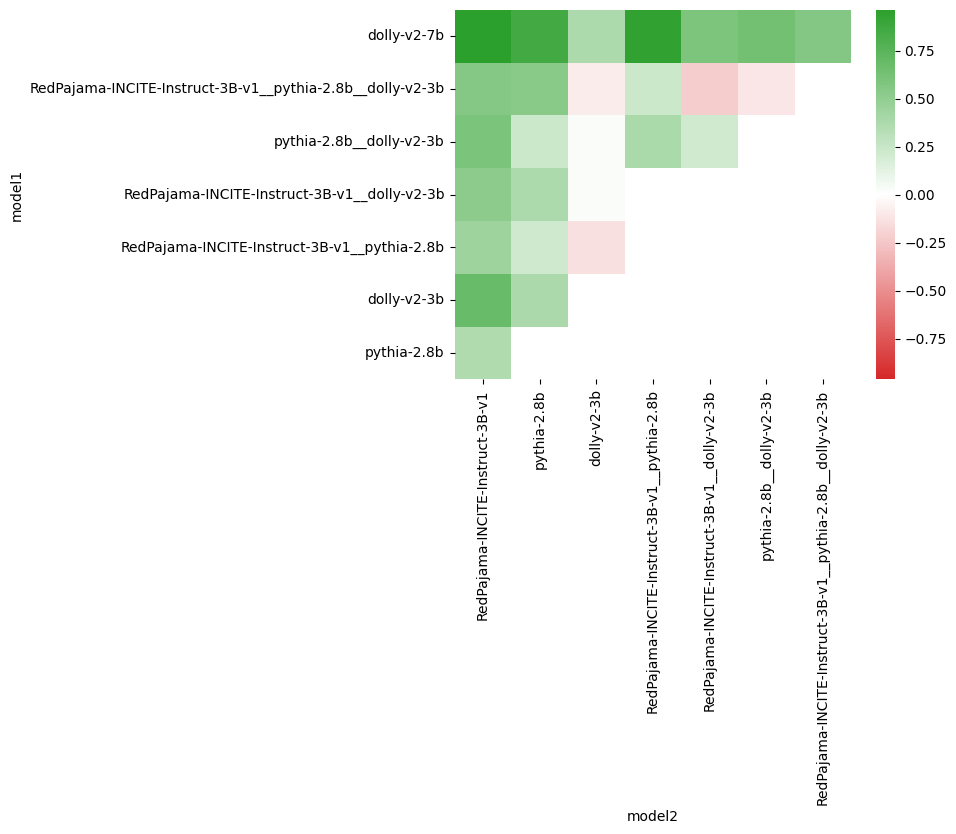

In [38]:
cmap = mcolors.LinearSegmentedColormap.from_list("custom", ["#d62728", "white", "#2ca02c"], N=256)
norm = CenteredNorm()

sns.heatmap(df, cmap=cmap, norm=norm)

In [72]:
pd.isna(df.iloc[2, 5])

True

In [73]:
cols = df.index.union(df.columns)
scores = pd.DataFrame(columns=cols, index=cols).fillna(0)

for model1 in cols:
    for model2 in cols:
        if model1 == model2:
            continue
#         if model1 not in df.index and model1 not in df.columns:
#             print(model1)
        if model1 in df.columns and model2 in df.index and not pd.isna(df.loc[model2, model1]):
            scores.loc[model1, model2] = df.loc[model2, model1]
            scores.loc[model2, model1] = -df.loc[model2, model1]
        elif model1 in df.index and model2 in df.columns and not pd.isna(df.loc[model1, model2]):
            scores.loc[model1, model2] = df.loc[model1, model2]
            scores.loc[model2, model1] = -df.loc[model1, model2]
        else:
            print(model1)
scores

,RedPajama-INCITE-Instruct-3B-v1,RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b,RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b,RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b,dolly-v2-3b,dolly-v2-7b,pythia-2.8b,pythia-2.8b__dolly-v2-3b
RedPajama-INCITE-Instruct-3B-v1,0.0000,-0.5250,-0.4375,-0.5500,-0.68750,-0.9625,-0.36250,-0.6000
RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b,0.5250,0.0000,-0.0000,0.2250,-0.02500,-0.5875,-0.37500,-0.2125
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b,0.4375,0.0000,0.0000,-0.2375,0.13750,-0.9375,-0.22500,-0.3875
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b,0.5500,-0.2250,0.2375,0.0000,0.08750,-0.5625,-0.53750,0.1125
dolly-v2-3b,0.6875,0.0250,-0.1375,-0.0875,0.00000,-0.3750,-0.38125,-0.0250
dolly-v2-7b,0.9625,0.5875,0.9375,0.5625,0.37500,0.0000,-0.85000,-0.6375
pythia-2.8b,0.3625,0.3750,0.2250,0.5375,0.38125,0.8500,0.00000,-0.2375
pythia-2.8b__dolly-v2-3b,0.6000,0.2125,0.3875,-0.1125,0.02500,0.6375,0.23750,0.0000


In [88]:
scores.index

Int64Index([0, 1, 1, 2, 0, 0, 0, 1], dtype='int64')

In [90]:
scores = scores.sort_index(axis=1, key=lambda x: x.map(lambda x: x.count('__')))
scores = scores.sort_index(axis=0, key=lambda x: x.map(lambda x: x.count('__')))

<Axes: >

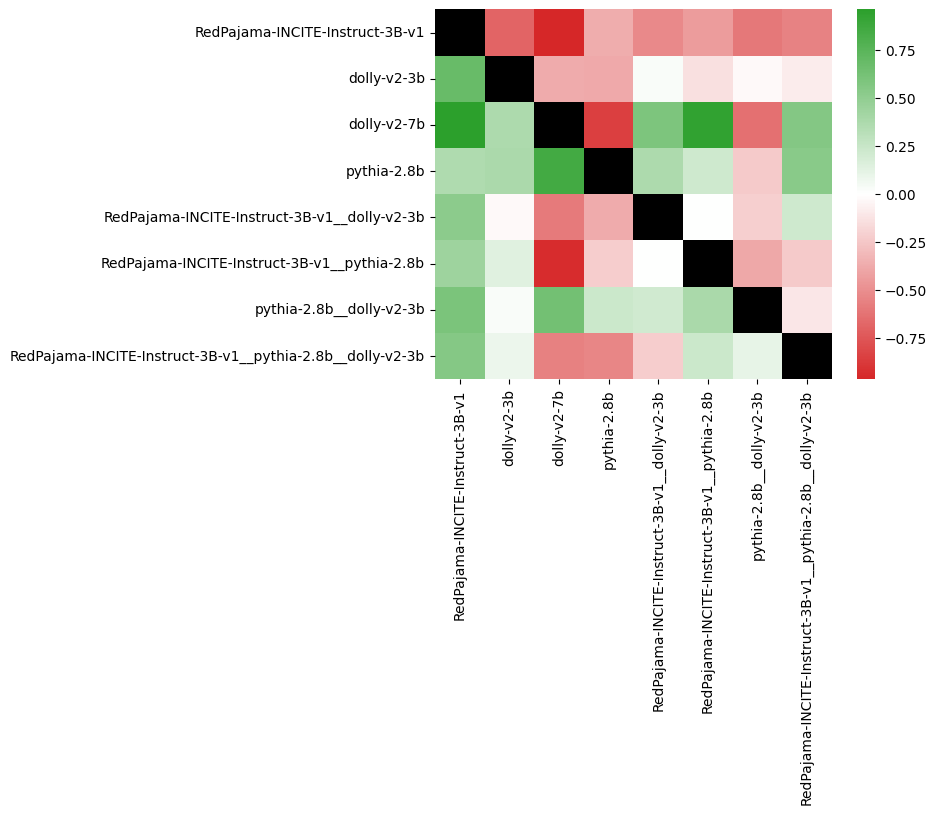

In [91]:
mask = np.ones_like(scores, dtype=bool)
np.fill_diagonal(mask, 0)

# Create a heatmap with the custom colormap and centered normalization
sns.heatmap(scores, mask=~mask, cmap=cmap, norm=norm)

# Now draw the diagonal elements with black color
sns.heatmap(scores, mask=mask, cmap=['black'], cbar=False)

In [95]:
data

[{'review_id': 'D6967LPWoXhnhmdTpssTYB',
  'question_id': 1,
  'answer1_id': 'bzArArzWXVrBgZcjWq3SHw',
  'answer2_id': '7Q2gNfLegU98VzgkgT5zD8',
  'reviewer_id': 1,
  'metadata': {},
  'text': '7 8\n\nAssistant 1 provided some good tips for improving time management skills, but the responses were somewhat brief and lacked specific examples. Assistant 2 provided more detailed and specific advice, including suggestions for blocking out time for activities and organizing your day. Overall, both assistants provided helpful responses, but Assistant 2 was more comprehensive and relevant to the question.',
  'score': [7.0, 8.0]},
 {'review_id': 'MRyHnQSP7mC7pS7ViwBHWy',
  'question_id': 2,
  'answer1_id': 'hRobPFW5FULWbDRh7dvhMc',
  'answer2_id': 'K8huGZgSmgwK5vDosAquv6',
  'reviewer_id': 1,
  'metadata': {},
  'text': "7 8\n\nAssistant 1 provided a concise and straightforward answer to the question, highlighting the importance of taking a break, finding a healthy outlet, or seeking help from

In [100]:
questions

[{'question_id': 1,
  'text': 'How can I improve my time management skills?',
  'category': 'generic'},
 {'question_id': 2,
  'text': 'What are the most effective ways to deal with stress?',
  'category': 'generic'},
 {'question_id': 3,
  'text': 'What are the main differences between Python and JavaScript programming languages?',
  'category': 'generic'},
 {'question_id': 4,
  'text': 'How can I increase my productivity while working from home?',
  'category': 'generic'},
 {'question_id': 5,
  'text': 'Can you explain the basics of quantum computing?',
  'category': 'generic'},
 {'question_id': 6,
  'text': 'What are the differences between plant-based and animal-based protein sources?',
  'category': 'generic'},
 {'question_id': 7,
  'text': 'How can I develop my critical thinking skills?',
  'category': 'generic'},
 {'question_id': 8,
  'text': 'What are the major challenges faced by the education sector today?',
  'category': 'generic'},
 {'question_id': 9,
  'text': 'What are the 

In [125]:
res = []

for file in os.listdir('generative_res/gpt3.5-review/'):
    path = f'generative_res/gpt3.5-review/{file}'
    print(file)
    if '-vs-' not in file:
        continue
    model1, model2 = file.split('-vs-')
    with open(path) as f:
        data = [json.loads(line) for line in f]
    with open('generative_res/question.jsonl') as f:
        questions = [json.loads(line) for line in f]
    with open(f'generative_res/answer/{model1}.jsonl') as f:
        answer1 = [json.loads(line) for line in f]
    with open(f'generative_res/answer/{model2}.jsonl') as f:
        answer2 = [json.loads(line) for line in f]
    for idx, (r, q, a1, a2) in enumerate(zip(data, questions, answer1, answer2)):
        res.append(dict(
            model1=model1,
            model2=model2,
            score1=r['score'][0],
            score2=r['score'][1],
            review=r['text'],
            question=q['text'],
            answer1=a1['text'],
            answer2=a2['text'],
            category=q['category'],
            qid=idx
        ))
    

RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b-vs-RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b
RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b-vs-RedPajama-INCITE-Instruct-3B-v1
dolly-v2-7b-vs-RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b-vs-pythia-2.8b
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b-vs-dolly-v2-3b
dolly-v2-3b-vs-RedPajama-INCITE-Instruct-3B-v1
pythia-2.8b__dolly-v2-3b-vs-dolly-v2-3b
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b-vs-RedPajama-INCITE-Instruct-3B-v1
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b-vs-pythia-2.8b
dolly-v2-3b-vs-pythia-2.8b
pythia-2.8b__dolly-v2-3b-vs-pythia-2.8b
dolly-v2-7b-vs-RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b-vs-dolly-v2-3b
pythia-2.8b-vs-RedPajama-INCITE-Instruct-3B-v1
dolly-v2-7b-vs-RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b
RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b-vs-pythia-2.8b
dolly-v2-7b-vs-pythia-2.8b_

In [126]:
df = pd.DataFrame(res)

In [127]:
model_name = 'RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b'
df[(df.model1 == model_name) & (df.score1 - df.score2 > 4)]

model1  \
74    RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b   
102   RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b   
138   RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b   
141   RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b   
152   RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b   
156   RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b   
1241  RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b   
2102  RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b   
2120  RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b   
2129  RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b   

                                            model2  score1  score2  \
74    RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b     9.0     4.0   
102                RedPajama-INCITE-Instruct-3B-v1     7.0     2.0   
138                RedPajama-INCITE-Instruct-3B-v1     8.0     2.0   
141                RedPajama-INCITE-Instruct-3B-v1     7.0     2.0   
152                RedPajama-INCITE-Instruct-3B-v1     8.0     2.0   
156                RedPajama-INCITE-Instruct-3B-v1     7.0     2.0   
1241                                   pythia-2.8b     7.0     2.0   
2102                                   dolly-v2-3b     7.0     2.0   
2120                                   dolly-v2-3b     8.0     2.0   
2129                                   dolly-v2-3b     7.0     2.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   review  \
74                                                   9 4\n\nAssistant 1 provided a short and generic response that lacks detail and personalization. While the apology is present, there is no explanation or reassurance that the issue has been resolved. However, the response is relevant to the question.\n\nAssistant 2's response is not helpful or accurate, as it places blame on the customer and does not provide an apology or reassurance that the issue has been resolved. The response lacks detail and personalization, and is not relevant to the question.\n\nOverall, Assistant 1's response is more helpful, accurate, and relevant to the question, but could benefit from more detail and personalization. Assistant 2's response is not helpful or accurate, and lacks detail and personalization.   
102                                                                                                                                                                                                                                                                                                                                                                                                   7 2\n\nAssistant 1 provided a relevant and helpful response to the question by acknowledging the Shakespearean context and suggesting a soliloquy as a means of declaring love. However, the response lacked detail and did not provide an example of how a soliloquy might sound. \n\nAssistant 2's response was not helpful or relevant to the question at hand, and did not provide any information or guidance.   
138                                                                                                            8 2\n\nAssistant 1 provided a somewhat relevant answer, but it did not directly address the question. The information about the Americas being a renewable energy source and hav

In [123]:
pd.set_option('display.max_colwidth', None)

In [124]:
df.iloc[74]

model1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b
model2                                                                                                                                                                                                                                                 

In [66]:
res = []

for file in os.listdir('generative_res/gpt3.5-review/'):
    path = f'generative_res/gpt3.5-review/{file}'
    print(file)
    if '-vs-' not in file:
        continue
    model1, model2 = file.split('-vs-')
    with open(path) as f:
        data = [json.loads(line) for line in f]
    score = sum(line['score'][0] > line['score'][1] for line in data) / len(data)
    res.append(dict(model1=model1, model2=model2, result=score))

RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b-vs-RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b
RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b-vs-RedPajama-INCITE-Instruct-3B-v1
dolly-v2-7b-vs-RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b-vs-pythia-2.8b
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b-vs-dolly-v2-3b
dolly-v2-3b-vs-RedPajama-INCITE-Instruct-3B-v1
pythia-2.8b__dolly-v2-3b-vs-dolly-v2-3b
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b-vs-RedPajama-INCITE-Instruct-3B-v1
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b-vs-pythia-2.8b
dolly-v2-3b-vs-pythia-2.8b
pythia-2.8b__dolly-v2-3b-vs-pythia-2.8b
dolly-v2-7b-vs-RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b-vs-dolly-v2-3b
pythia-2.8b-vs-RedPajama-INCITE-Instruct-3B-v1
dolly-v2-7b-vs-RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b
RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b-vs-pythia-2.8b
dolly-v2-7b-vs-pythia-2.8b_

In [67]:
df = pd.DataFrame(res).pivot(index='model1', columns='model2', values='result')
df = df.iloc[df.isnull().sum(axis=1).argsort()]
df = df.iloc[:, [0, 5, 4, 2, 1, 6, 3]]
df

model2,RedPajama-INCITE-Instruct-3B-v1,pythia-2.8b,dolly-v2-3b,RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b,RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b,pythia-2.8b__dolly-v2-3b,RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b
model1,,,,,,,
dolly-v2-7b,0.5000,0.5125,0.3750,0.55,0.5125,0.475,0.475
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b,0.4250,0.4625,0.2625,0.35,0.2125,0.300,NaN
pythia-2.8b__dolly-v2-3b,0.3875,0.3750,0.3000,0.40,0.3250,NaN,NaN
RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b,0.4000,0.4375,0.3125,0.30,NaN,NaN,NaN
RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b,0.3750,0.3625,0.2375,NaN,NaN,NaN,NaN
dolly-v2-3b,0.4125,0.4125,NaN,NaN,NaN,NaN,NaN
pythia-2.8b,0.3625,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
'generative_res/gpt3.5-review/dolly-v2-7b-vs-RedPajama-INCITE-Instruct-3B-v1'

In [163]:
import os
import json
import pandas as pd

def aggregate_results(participant, directory):
    # Initialize the results as an empty list
    results = []

    # Iterate through each file in the directory
    for filename in os.listdir(directory):
        # Parse the filename to identify the competitors
        if '-vs-' not in filename: continue
        competitor1, competitor2 = filename.split('-vs-')

        # Only process files that include the participant
        if participant not in [competitor1, competitor2]:
            continue

        # Initialize the counts for this competitor
        wins = ties = losses = 0

        # Open the file and read the JSON lines
        with open(os.path.join(directory, filename), 'r') as file:
            for line in file:
                # Parse the JSON line
                data = json.loads(line)

                # Determine the index of the participant in the score array
                index = 0 if competitor1 == participant else 1

                # Calculate the wins, losses, and ties
                if data['score'][index] > data['score'][1 - index]:
                    wins += 1
                elif data['score'][index] < data['score'][1 - index]:
                    losses += 1
                else:
                    ties += 1

        # Add the results for this competitor to the list
        results.append([competitor1 if participant != competitor1 else competitor2, wins, ties, losses])

    # Create a pandas DataFrame from the results
    df = pd.DataFrame(results, columns=['Model', 'Wins', 'Tie', 'Lose'])

    return df

In [164]:
import matplotlib.pyplot as plt

def plot_results(res, name):
    # Create a new DataFrame with the columns in the desired order
    plot_df = res[['Wins', 'Tie', 'Lose',]]
    colors = ['#90ee90', '#fcdb6d', '#ff7f7f',]  # red, yellow, green
    plot_df.index = res.Model.apply(lambda x: x.replace('__', '+\n') + '  ')
    plot_df.columns = ['Win', 'Tie', 'Lose']

    # Create the bar plot
    plot = plot_df.plot.barh(stacked=True, color=colors, xlim=(0, 80))

    # Add labels
    plt.xlabel('Number of games')
    plt.ylabel('Model')

    plt.gca().invert_yaxis()

    # Place the legend outside the plot area, at the top
    plt.legend(bbox_to_anchor=(0.5, 1.), loc='lower center', borderaxespad=0., ncol=3)

    # Show the plot
    plt.show()

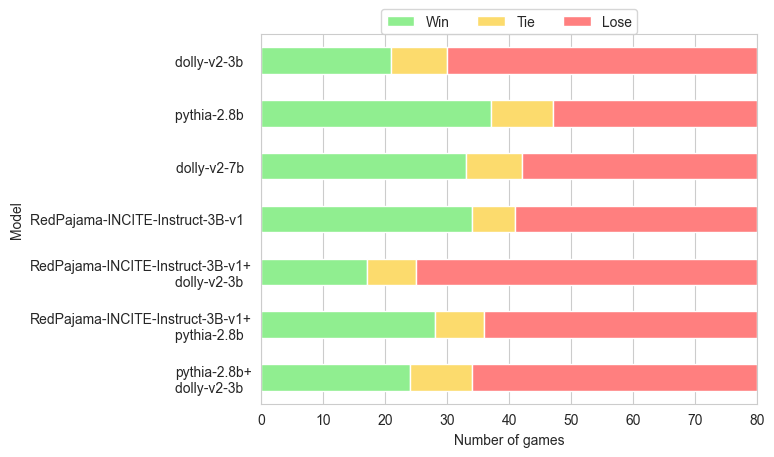

In [165]:
res = aggregate_results(
    'RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b',
    'generative_res/gpt3.5-review/'
).sort_values('Model', key=lambda x: x.str.count('_'))

plot_results(res, 'RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b')

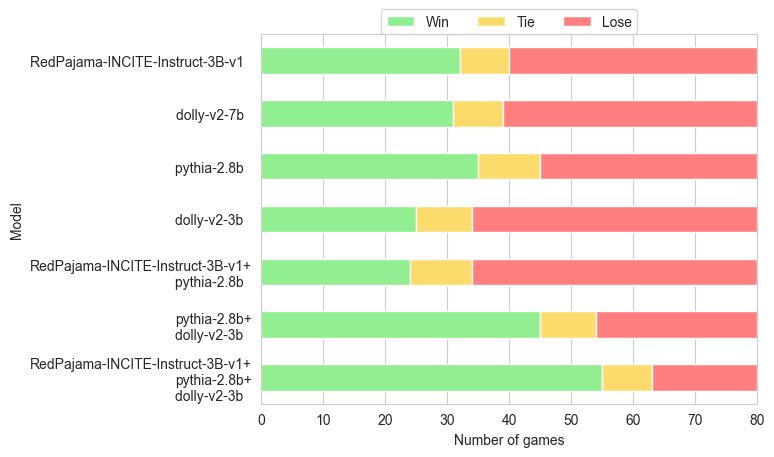

In [129]:
res = aggregate_results(
    'RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b',
    'generative_res/gpt3.5-review/'
).sort_values('Model', key=lambda x: x.str.count('_'))

plot_results(res, 'RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b')

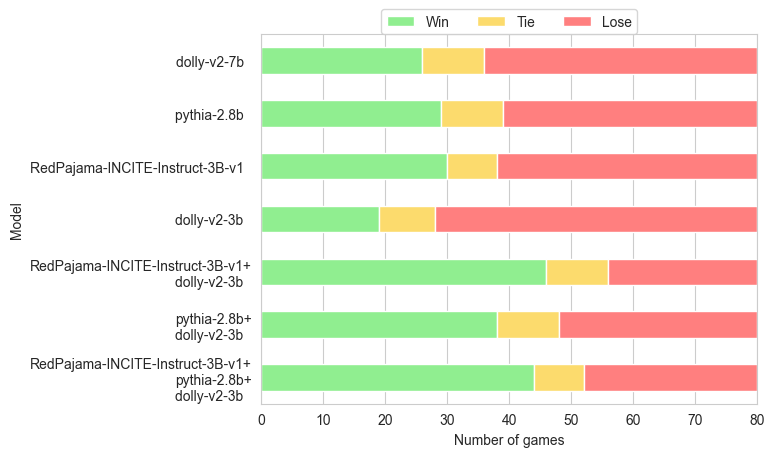

In [130]:
res = aggregate_results(
    'RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b',
    'generative_res/gpt3.5-review/'
).sort_values('Model', key=lambda x: x.str.count('_'))

plot_results(res, 'RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b')

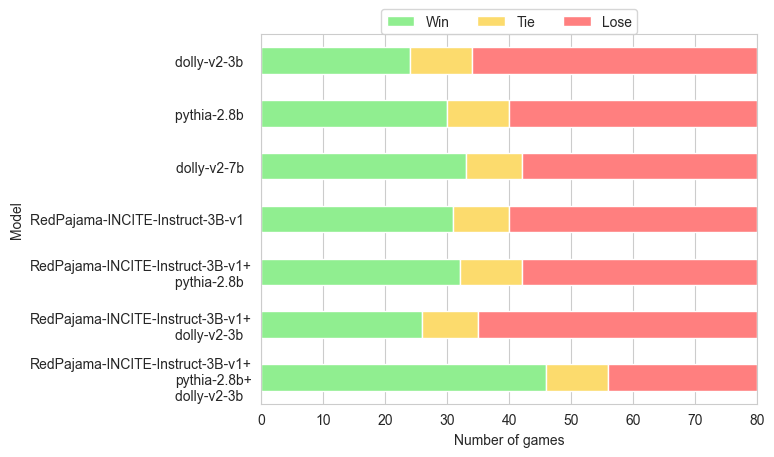

In [131]:
res = aggregate_results(
    'pythia-2.8b__dolly-v2-3b',
    'generative_res/gpt3.5-review/'
).sort_values('Model', key=lambda x: x.str.count('_'))

plot_results(res, 'pythia-2.8b__dolly-v2-3b')

In [242]:
def read_data(competition_path, order):
    with open(f'generative_res/gpt3.5-review/{competition_path}') as f,\
        open('generative_res/question.jsonl') as q:
        data = pd.DataFrame([json.loads(line) for line in f])
        data['category'] = [json.loads(line)['category'] for line in q]

        data['score1'] = data.score.apply(lambda x: x[order])
        data['score2'] = data.score.apply(lambda x: x[1-order])
        

        data['win'] = data['score1'] > data['score2']
        data['lose'] = data['score1'] < data['score2']
        data['draw'] = data['score1'] == data['score2']
    return data

# def plot_groupped(res, name):
#     # Create a new DataFrame with the columns in the desired order
#     plot_df = res[['win', 'draw', 'lose',]]
#     colors = ['#90ee90', '#fcdb6d', '#ff7f7f',]  # red, yellow, green
#     plot_df.index = res.index # res.category.apply(lambda x: x.replace('__', '+\n') + '  ')
#     plot_df.columns = ['Win', 'Tie', 'Lose']

#     # Create the bar plot
#     plot = plot_df.plot.barh(stacked=True, color=colors, xlim=(0, 10))

#     # Add labels
#     plt.title(name.replace('-vs-', r'  $\bf{vs}$  ').replace('__', r' $\bf{+}$ '), y=1.0, pad=25)
#     plt.xlabel('Number of games')
#     plt.ylabel('Category')

#     plt.gca().invert_yaxis()

#     # Place the legend outside the plot area, at the top
#     plt.legend(bbox_to_anchor=(0.5, 1.), loc='lower center', borderaxespad=0., ncol=3)

#     # Show the plot
#     plt.show()

def plot_groupped(res, name, ax):
    plot_df = res[['win', 'draw', 'lose',]]
    colors = ['#90ee90', '#fcdb6d', '#ff7f7f',]  # red, yellow, green
    plot_df.index = res.index 
    plot_df.columns = ['Win', 'Tie', 'Lose']

    plot = plot_df.plot.barh(stacked=True, color=colors, xlim=(0, 10), ax=ax)

    ax.set_title(name.replace('-vs-', r'  $\bf{vs}$  ').replace('__', r' $\bf{+}$ '), y=1.0, pad=25)
    ax.set_xlabel('Number of games')
    ax.set_ylabel('Category')
    ax.invert_yaxis()

    ax.legend(bbox_to_anchor=(0.5, 1.), loc='lower center', borderaxespad=0., ncol=3)

In [223]:
os.listdir('generative_res/gpt3.5-review/')

['RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b-vs-RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b',
 'RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b-vs-RedPajama-INCITE-Instruct-3B-v1',
 'dolly-v2-7b-vs-RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b',
 'RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b-vs-pythia-2.8b',
 'RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b-vs-dolly-v2-3b',
 'dolly-v2-3b-vs-RedPajama-INCITE-Instruct-3B-v1',
 'pythia-2.8b__dolly-v2-3b-vs-dolly-v2-3b',
 'RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b-vs-RedPajama-INCITE-Instruct-3B-v1',
 'RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b-vs-pythia-2.8b',
 'dolly-v2-3b-vs-pythia-2.8b',
 'pythia-2.8b__dolly-v2-3b-vs-pythia-2.8b',
 'dolly-v2-7b-vs-RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b',
 'RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b-vs-dolly-v2-3b',
 'pythia-2.8b-vs-RedPajama-INCITE-Instruct-3B-v1',
 'dolly-v2-7b-vs-RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b',
 'RedPajama-INCITE-Instruct

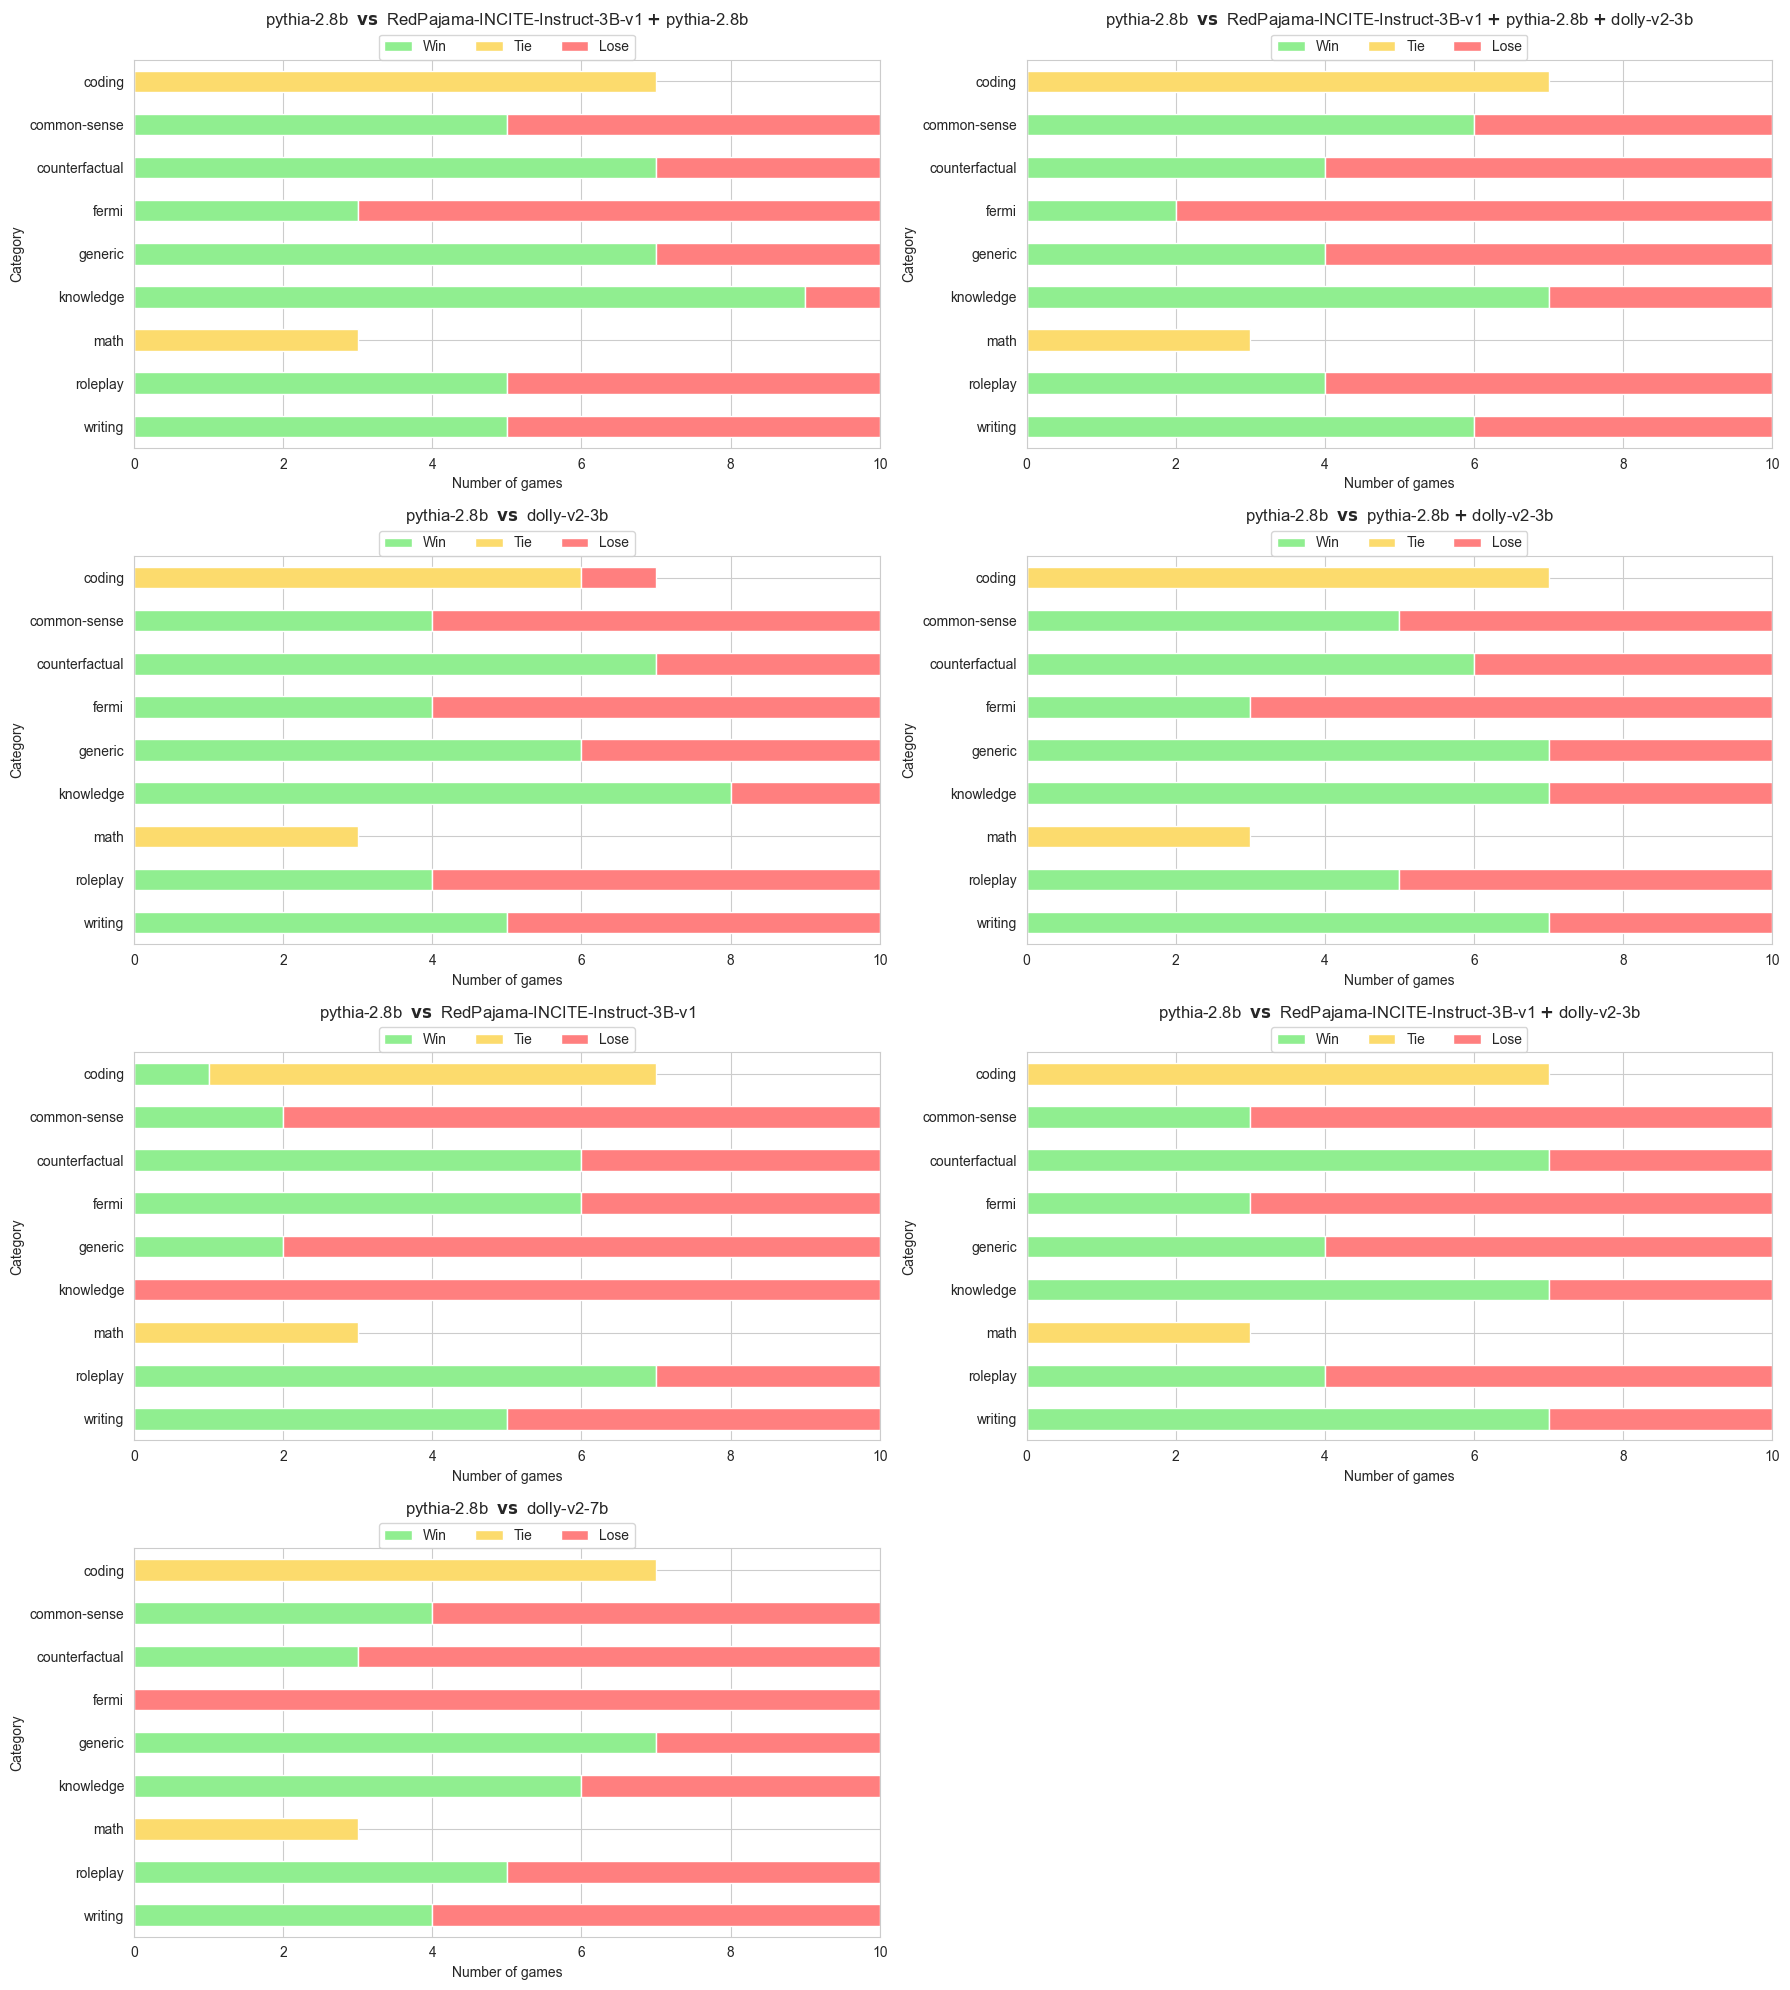

In [248]:
participant = 'pythia-2.8b'
i = 1
plt.figure(figsize=(18, 20))

    
for competition in os.listdir('generative_res/gpt3.5-review/'):
    if '-vs-' not in competition: continue
    competitor1, competitor2 = competition.split('-vs-')

    # Only process files that include the participant
    if participant not in [competitor1, competitor2]:
        continue
        
    ax = plt.subplot(4, 2, i)  
    i += 1
    data = read_data(competition, competitor2==participant)

    plot_groupped(
        data.groupby('category')[['win', 'draw', 'lose']].sum(),
        '-vs-'.join([competitor1, competitor2] if competitor1==participant else [competitor2, competitor1]),
        ax
    )

plt.tight_layout()

In [270]:
def calculate_elo_rank(player_a_rank, player_b_rank, score_a):
    """Calculate the new Elo rank of a player

    Args:
        player_a_rank (float): The current rank of player A
        player_b_rank (float): The current rank of player B
        score_a (int): The score of player A (1 for win, 0.5 for draw, 0 for loss)

    Returns:
        new_rank_a: The new rank of player A
    """
    # Calculate the expected score of Player A
    expected_score_a = 1.0 / (1.0 + 10.0 ** ((player_b_rank - player_a_rank) / 400.0))

    # K-factor determines how much rank changes - you may wish to use a different value
    k_factor = 32

    # Update the rank of Player A
    new_rank_a = player_a_rank + k_factor * (score_a - expected_score_a)
    
    return new_rank_a

def calculate_new_ratings(data):
    """
    Calculate Elo ratings for multiple players given a list of match results.
    
    Args:
        data: A list of dicts, each representing a match. Each dict should have 
              a 'players' field listing the two players in the match and a 'score' 
              field giving the score for each player, e.g.:
              [{"players": [model1, model2], "score": [score1, score2]}, ...]
              
    Returns:
        A dictionary with the final Elo ratings for each player.
    """

    # Initialize a dictionary to store current ratings
    ratings = {}

    # Initialize all players with a rating of 1500 (common starting value in Elo)
    for match in data:
        for player in match['players']:
            if player not in ratings:
                ratings[player] = 1500

    # Iterate over the matches and update ratings
    for match in data:
        player_a, player_b = match['players']
        score_a = match['score'][0] / 10
        score_b = 1 - score_a

        # Calculate the new Elo rating for each player
        new_rating_a = calculate_elo_rank(ratings[player_a], ratings[player_b], score_a)
        new_rating_b = calculate_elo_rank(ratings[player_b], ratings[player_a], 1 - score_b)

        # Update the ratings dictionary
        ratings[player_a] = new_rating_a
        ratings[player_b] = new_rating_b

    return ratings

data = []
for competition in os.listdir('generative_res/gpt3.5-review/'):
    if '-vs-' not in competition: continue
    competitor1, competitor2 = competition.split('-vs-')
    
    with open(f'generative_res/gpt3.5-review/{competition}') as f:
        for line in f:
            new_row = json.loads(line)
            new_row['players'] = [competitor1, competitor2]
            data.append(new_row)
print(            
    pd.DataFrame(
        calculate_new_ratings(data).items(), columns=['model', 'elo rating']
    ).sort_values('elo rating', ascending=False).round().style.to_latex()
)

\begin{tabular}{llr}
 & model & elo rating \\
5 & RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b__dolly-v2-3b & 4539.000000 \\
7 & pythia-2.8b__dolly-v2-3b & 4539.000000 \\
2 & RedPajama-INCITE-Instruct-3B-v1 & 4339.000000 \\
0 & RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b & 4007.000000 \\
6 & dolly-v2-3b & 4007.000000 \\
3 & dolly-v2-7b & 3742.000000 \\
4 & pythia-2.8b & 3741.000000 \\
1 & RedPajama-INCITE-Instruct-3B-v1__pythia-2.8b & 3735.000000 \\
\end{tabular}



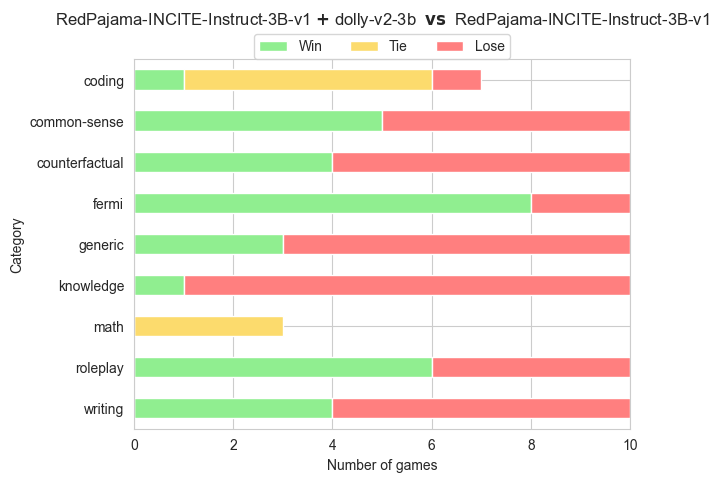

In [218]:
competition = 'RedPajama-INCITE-Instruct-3B-v1__dolly-v2-3b-vs-RedPajama-INCITE-Instruct-3B-v1'
data = read_data(competition)

plot_groupped(
    data.groupby('category')[['win', 'draw', 'lose']].sum(),
    competition
)

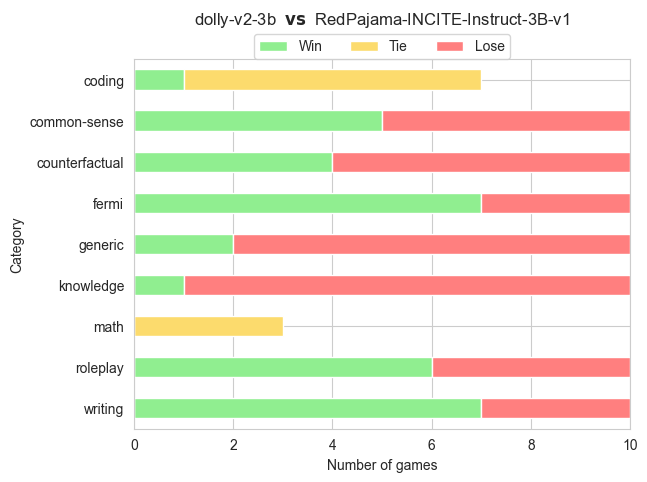

In [221]:
competition = 'dolly-v2-3b-vs-RedPajama-INCITE-Instruct-3B-v1'
data = read_data(competition)

plot_groupped(
    data.groupby('category')[['win', 'draw', 'lose']].sum(),
    competition
)

In [189]:
'generative_res/gpt3.5-review/dolly-v2-3b-vs-RedPajama-INCITE-Instruct-3B-v1'

,win,draw,lose
question_category,,,
coding,1,6,0
common-sense,5,0,5
counterfactual,4,0,6
fermi,7,0,3
generic,2,0,8
knowledge,1,0,9
math,0,3,0
roleplay,6,0,4
writing,7,0,3


In [ ]:
results = []
directory = 'generative_res/gpt3.5-review/'
participant = 'dolly-v2-3b'

# Iterate through each file in the directory
for filename in os.listdir(directory):
    # Parse the filename to identify the competitors
    if '-vs-' not in filename: continue
    competitor1, competitor2 = filename.split('-vs-')

    # Only process files that include the participant
    if participant not in [competitor1, competitor2]:
        continue

    # Open the file and read the JSON lines
    with open(os.path.join(directory, filename), 'r') as file:
        for line in file:
            # Parse the JSON line
            data = json.loads(line)

            # Determine the index of the participant in the score array
            index = 0 if competitor1 == participant else 1

            # Calculate the wins, losses, and ties
            if data['score'][index] > data['score'][1 - index]:
                wins += 1
            elif data['score'][index] < data['score'][1 - index]:
                losses += 1
            else:
                ties += 1

    # Add the results for this competitor to the list
    results.append([competitor1 if participant != competitor1 else competitor2, wins, ties, losses])

# Create a pandas DataFrame from the results
df = pd.DataFrame(results, columns=['Model', 'Wins', 'Tie', 'Lose'])

In [159]:
df = []
for filename in os.listdir('lm_evaluation_data/'):
    with open(f'lm_evaluation_data/{filename}') as f:
        res = [json.loads(x) for x in f]
        df.append(dict(
            name=filename[:-6],
            number_of_samples=len(res),
            number_of_classes=len(res[0]['candidates'])
        ))

In [161]:
df = pd.DataFrame(df)
df.columns = ['Name', '# samples', '# classes']
print(df.style.to_latex())

\begin{tabular}{llrr}
 & Name & # samples & # classes \\
0 & race-middle & 1436 & 4 \\
1 & hellaswag & 10042 & 4 \\
2 & arc-challenge & 1172 & 4 \\
3 & race-high & 3498 & 4 \\
4 & arc-easy & 2376 & 4 \\
5 & boolq & 3270 & 2 \\
6 & winogrande & 1267 & 2 \\
7 & piqa & 1838 & 2 \\
8 & rte & 277 & 2 \\
\end{tabular}



In [139]:
with open('generative_res/question.jsonl') as f:
    data = [json.loads(x) for x in f]
df = pd.DataFrame(data)

In [144]:
s = df.sample(5)
s

,question_id,text,category
58,59,What if Christopher Columbus had not discovere...,counterfactual
6,7,How can I develop my critical thinking skills?,generic
76,77,Compose an engaging travel blog post about a r...,writing
12,13,How can governments utilize fiscal and monetar...,knowledge
69,70,"If the endpoints of a line segment are (2, -2)...",math


In [148]:
print(s[['category', 'text']].style.to_latex())

\begin{tabular}{lll}
 & category & text \\
58 & counterfactual & What if Christopher Columbus had not discovered the Americas? \\
6 & generic & How can I develop my critical thinking skills? \\
76 & writing & Compose an engaging travel blog post about a recent trip to Hawaii, highlighting cultural experiences and must-see attractions. \\
12 & knowledge & How can governments utilize fiscal and monetary policies to combat economic recessions? \\
69 & math & If the endpoints of a line segment are (2, -2) and (10, 4), what is the length of the segment? \\
\end{tabular}



In [135]:
s = '''

\section{Introduction}

In recent years, large language models (LLMs) have emerged as a transformative force in the realm of artificial intelligence (AI) research. These models leverage vast quantities of data to generate human-like text. They are pre-trained on a large corpus of text and fine-tuned for specific tasks, demonstrating impressive performance on a multitude of natural language processing (NLP) benchmarks.

 Another subject of our research, ensemble techniques, have a long history in machine learning, tracing back to the concept of "bagging" proposed by Breiman (1996) and "boosting" introduced by Freund and Schapire (1997). These methods, by combining multiple models' predictions, aim to create a composite model that outperforms any individual model in the ensemble. Bagging reduces variance by training models on different subsets of data, while boosting incrementally builds an ensemble by focusing on instances that previous models misclassified.

Over the years, ensemble techniques have evolved, encompassing methods like stacking, where the predictions of base models are used as input for a second-level model, and voting, where each model in the ensemble votes for a class, and the class with the majority votes is chosen as the final output. These techniques have been successfully applied to numerous machine learning tasks, often yielding improvements in prediction accuracy, robustness, and generalization.

[TBE]
To perform well, classic ensemble approaches such as bagging require base models to be diverse. From the perspective of Bias-Variance Decomposition [LINK], this is explained in the following way: ensembles reduce variance while keeping bias the same. And gain from ensembling depends on correlation between base models. For example, in the best case scenario, when models are uncorrelated, Bagging reduces Variance by N times. 

[TBE]
Since LLMs learn using self-supervised technique (next token prediction) and use web-scale datasets typically containing ~ 1 trillion of tokens (which may vary a lot from model to model), they are perfect candidates for composing ensembles. Previous works have shown effectiveness of NNs' ensembles trained on the same dataset with same architecture and with different random initialization. We aim to explore more general thing - performance of LLMs ensembles with some differences not only in architectures, but also in training data. And measure improvement of LLM ensembles over single LLMs.

To achieve our goal we aim to solve the following tasks:

\begin{itemize}

\item Combine models with similar architecture and pretrain dataset and different embeddings for classification task
\item Combine models with similar architectures and different pretrain dataset for classification task
\item Combine models using different aggregation function for classification task
\item Compare models for generation task
\item Compare model’s performance
\end{itemize}

\section{Related Work}

\section{Background}

In this section we thoroughly describe leveraged language models and benchmarks.

\subsection{GPT Model Architecture}

The GPT, or Generative Pretrained Transformer, model leverages the transformer architecture and is designed to generate human-like text. The underlying transformer architecture was introduced by [LINK] Vaswani et al. in the "Attention is All You Need" paper, and it has become a standard in many natural language processing tasks.

[IMAGE]

The GPT model utilizes the decoder part of the transformer architecture. The transformer's decoder is a stack of identical layers, with each layer comprising two sub-layers: a multi-head self-attention mechanism and a position-wise fully connected feed-forward network.

The multi-head attention mechanism allows the model to focus on different parts of the input sequence when generating each word in the output sequence. This is achieved by computing the attention function (usually a scaled dot-product attention) multiple times in parallel.

The position-wise fully connected feed-forward network consists of two linear transformations with a ReLU activation function in between. Importantly, the GPT model uses a masked self-attention mechanism in its decoder to ensure that the predictions for position 'i' can depend only on positions before 'i'.

One key aspect of GPT and other transformer-based models is the incorporation of positional encodings, which are added to the input embeddings to provide the model with information about the relative or absolute position of the words in the sequence.

The training process of GPT models involves two steps: pretraining and fine-tuning.

Pretraining: In this phase, the model is trained on a large corpus of text data in an unsupervised manner. The objective is to predict the next word in a sentence given the preceding words. This process leverages a language modeling objective and allows the model to learn a wide array of language patterns and structures.

Fine-tuning: Once pretraining is complete, the model is fine-tuned on a specific task. This involves continued training on a smaller, task-specific dataset. The fine-tuning step adapts the general language understanding learned from the pretraining step to the specific task at hand. For instance, if the task is sentiment analysis, the model is fine-tuned on a sentiment analysis dataset.

This two-step process is one of the primary reasons for the success of GPT and similar models. The pretraining step enables the model to learn a broad understanding of language, while the fine-tuning step allows it to adapt this understanding to a wide variety of tasks.

\subsection{GPT Variations}

In our work we leverage different variations of GPT model with slight difference in architecture and pre-training datasets.

\subsubsection{NVLLM}

This is a version of GPT trained by NVIDIA using Megatron framework. In this work we use 1.3B models with different types of positional embeddings: standard, alibi, rope, sandwich [LINK][LINK][LINK][LINK]. Pre-training dataset and other hyperparameters are unknown [TBE].

\subsubsection{GPT2}

\subsubsection{Cerebras-GPT}

\subsubsection{OPT}

\subsubsection{GPT-Neo}

\subsubsection{Dolly}

\subsubsection{StableLLM}

\subsection{Benchmarks}

In our work we investigate LLMs performance in two different tasks: generation and classification.

For classification we use lm-evaluation benchmark [LINK] proposed by AI21, consisting of 9 tasks of multilabel classification: arc-challenge, arc-easy, race-middle, race-high, winogrande, hellaswag, rte, piqa, boolq ([TABLE] with sizes, n classes, [TABLE] with examples).[TBE] what are these tasks.
To examine LLM performance these tasks use accuracy.

For generation we leverage benchmark, proposed by Stanford Lab [LINK]. It consists of 80 questions on 8 different topics (10 questions each) [TABLE with examples].
Each question implies a detailed answer. To assess model answers authors suggest a method of prompting of ChatGPT model, which is used in latest works as an AI-assessor [LINK where it is used as assessors]. Model provided with pair of <first models' answer, second models' answer> gives scores to each answer as a human assessor would do. After that scores are aggregated across tasks or the whole dataset to obtain win rate or average score against the given model.

\section{Experiments}

In this section we describe our experiments setup, provide all results and analyze them.

General setup for experiments is the following (if other not stated). We use decoder-only gpt-like models pre-trained on large-scale text datasets of size up to 1T tokens to predict next token. To combine multiple models into ensemble we average logits (ouputs after the last embedding layer). All experiments are performed on a single A100 GPU.

To perform classification we concatenate question with each answer and compare probabilities of these prompts following the approach from [LINK].
% @techreport{J1WhitePaper,
%   author = {Lieber, Opher and Sharir, Or and Lenz, Barak and Shoham, Yoav},
%   title = {Jurassic-1: Technical Details And Evaluation},
%   institution = {AI21 Labs},
%   year = 2021,
%   month = aug,
% }
More formally, given question $\mathcal{Q}$ and multiple possible answers for it $\mathcal{A}_1, \mathcal{A}_2, \dots, \mathcal{A}_N$ we choose the one with the highest probability $\mathbb{P}(\mathcal{A}_i | \mathcal{Q})$ which is estimated using our language model.

\subsection{Model similarity}

In this experiment we explore how model similarity influences ensemble performance.

From the theory we know that diverse models make better ensembles. In practice, it is nearly impossible to mathematically analyze diversity of Transformers. Thus, we will empirically investigate and evaluate models with different degree of diversity.

\begin{figure}[h!]
    \centering
    \subfloat{{\includegraphics[width=0.45\textwidth]{portion_diversity_nvllm.png} }}%
    \qquad
    \subfloat{{\includegraphics[width=0.45\textwidth]{kl_diversity_nvllm.png} }}%
    \caption{Diversity of different combinations of nvllms. \textbf{Left figure} shows portion of disagreements in labels for a pair of models on arc-easy. \textbf{Right figure} shows average KL-Divergence between two probability distributions assigned to the answers by the pair of models on arc-easy.}%
    \label{fig:diversity_nvllm}%
\end{figure}

\ref{fig:diversity_nvllm} shows how much these models predictions vary on arc-easy dataset. Here the most similar models appeared to be \textbf{rope} and \textbf{sandwich} versions, while the most different are \textbf{alibi} and \textbf{default}. This potentially means that the first pair of models will benefit from ensembling less than the second one. [IMAGE]

Same investigation for hf models.


%Intuitive explanation is that diverse models have independent errors. Thus error of ensemble

\subsection{Aggregation functions}

In this experiment we investigate what is the best way to aggregate results of our ensemble models. We compare the following strategies for classification:
\begin{itemize}
    \item averaging of the logits before probability computation
    \item averaging of softmax with temperature over the logits
    \item voting
\end{itemize}
  

First of all, we calculate oracle accuracy for all pairwise ensembles of our models. Given predictions of two models we consider our oracle ensemble to be correct if at least one of the models predicted correct label. This metric shows maximum possible improvement that we can get from the correct aggregation of models predictions. 

\begin{figure}[h!]
	\centering
	\includegraphics[width=0.6\textwidth]{oracle_acc_nvllm.png}
	\caption{Oracle accuracy for gpt1.3b with different positional embeddings on the arc-easy task.}
	\label{fig:oracle_acc_nvllm}
\end{figure}

\ref{fig:oracle_acc_nvllm} shows this metric for different nvllms for arc-easy task. On the main diagonal there are single models accuracies which are around 0.48. However, the best possible performance of two-model combination gives +0.1 more accuracy. This means that appropriate aggregation may lead to huge improvement.

\begin{figure}[h!]
    \centering
    \subfloat{{\includegraphics[width=0.45\textwidth]{softmax_avg_nvllm.png} }}%
    \qquad
    \subfloat{{\includegraphics[width=0.45\textwidth]{temp_softmax_avg_nvllm.png} }}%
    \caption{Accuracy averaged across 9 tasks for different combinations of nvllms with different predictions aggregation strategies. Left figure shows accuracy with and without softmax (with temperature 1). Right figure shows accuracy for different temperatures before softmax aggregation.}%
    \label{fig:softmax_avg_nvllm}%
\end{figure}

\subsection{Text generation}

In this experiment we explore how text generation benefits from model ensembles. We use 3B parameters versions of open-source models from huggingface: Pythia, Dolly, RedPajama and 7B parameters version of Dolly. This approach gives us 4 possible versions of ensembles since we combine only 3B models: 3 ensembles of two models and one ensemble of all 3 models. Each model generates answers of at most 1024 tokens for every question using sampling with temperature $0.7$. After that ChatGPT scores all pairs of responses from 0 to 10 for each two models.

\begin{figure}[h!]
    \centering
    \subfloat{{\includegraphics[width=0.45\textwidth]{pythia_dolly.png} }}%
    \qquad
    \subfloat{{\includegraphics[width=0.45\textwidth]{RedPajama_dolly.png} }}%
    \qquad
    \subfloat{{\includegraphics[width=0.45\textwidth]{RedPajama_pythia.png} }}%
    \qquad
    \subfloat{{\includegraphics[width=0.45\textwidth]{RedPajama_pythia_dolly.png} }}%
    \caption{Competition between models in 80 tasks. \textbf{Upper left figure} shows results of Dolly + Pythia ensemble. \textbf{Upper right figure} shows results of Dolly + RedPajama ensemble. \textbf{Lower left figure} shows results of Pythia + RedPajama ensemble. \textbf{Lower right figure} shows results of Dolly + Pythia + RedPajama ensemble.}%
    \label{fig:one_vs_one}%
\end{figure}

\subsection{Performance}

Ensembles can always improve quality, but require more memory and time. In our approach ensembles do not require any additional training or heavy computation. Thus, time and memory scales linearly on number of ensembled models.

\begin{figure}[h!]
    \centering
    \subfloat{{\includegraphics[width=0.45\textwidth]{elapsed_time.png} }}%
    \qquad
    \subfloat{{\includegraphics[width=0.45\textwidth]{elapsed_memory.png} }}%
    \caption{Time and memory consumption of ensembles for different number of models. \textbf{Left figure} shows elapsed time in seconds for evaluation on the all 9 tasks of the classification benchmark. \textbf{Right figure} shows peak GPU memory usage in Megabytes for evaluation on the all 9 tasks of the classification benchmark.}%
    \label{fig:performance}%
\end{figure}

However, bottleneck may occur in communication between different devices. For generation task model is called multiple times to autoregressively generate token sequence one-by-one. Therefore logits of base models are averaged after every generation step. So if models are located on different devices vast amount of communication is required. This is roughly equivalent to the  single model is parallelism over multiple GPUs. Thereby ensembles for text generation tasks performs on par with similar-sized single models and could not benefit from their easily-paralleled structure.

Another important thing is how do transformers scale required computational resources depending on size and sequence length. To test this we use versions of pythia model of different sizes and measure time and memory required to perfrom single forward pass.  

\begin{figure}[h!]
    \centering
    \subfloat{{\includegraphics[width=0.45\textwidth]{relplot_time.png} }}%
    \qquad
    \subfloat{{\includegraphics[width=0.45\textwidth]{relplot_memory.png} }}%
    \caption{Time and memory consumption of ensembles for different number of models. \textbf{Left figure} shows elapsed time in seconds for evaluation on the all 9 tasks of the classification benchmark. \textbf{Right figure} shows peak GPU memory usage in Megabytes for evaluation on the all 9 tasks of the classification benchmark.}%
    \label{fig:performance}%
\end{figure}
'''
len(''.join(s.split()))

12997